# Practice 09 — Multilayer Perceptron (MLP)

Lec 06 강의 내용을 기반으로 **다층 퍼셉트론**을 구현합니다.

| # | 내용 | 구현 |
|---|---|---|
| 1 | XOR 문제 — 단층 vs 다층 | NumPy |
| 2 | Backpropagation 수동 구현 (행렬 연산) | NumPy |
| 3 | PyTorch autograd 검증 | PyTorch |
| 4 | Multi-class Criterion 변화 | PyTorch |
| 5 | PyTorch MLP — Digits Classification | `nn.Module` class |

In [38]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

---
# 1. XOR 문제 — 왜 다층이 필요한가?

XOR은 **선형 분리 불가능**한 문제입니다. 단층 퍼셉트론으로는 해결할 수 없고, 은닉층이 필요합니다.

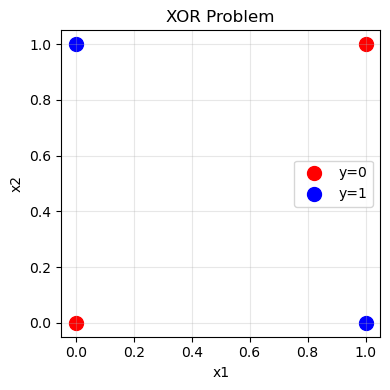

In [39]:
# XOR 데이터
X_xor = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float64)
Y_xor = np.array([[0], [1], [1], [0]], dtype=np.float64)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(X_xor[Y_xor.flatten()==0, 0], X_xor[Y_xor.flatten()==0, 1], c='r', s=100, label='y=0')
ax.scatter(X_xor[Y_xor.flatten()==1, 0], X_xor[Y_xor.flatten()==1, 1], c='b', s=100, label='y=1')
ax.set_title('XOR Problem'); ax.legend(); ax.grid(alpha=0.3)
ax.set_xlabel('x1'); ax.set_ylabel('x2')
plt.tight_layout(); plt.show()

### 단층 퍼셉트론 — 실패

In [40]:
# 단층 퍼셉트론으로 XOR 시도
X_t = torch.tensor(X_xor, dtype=torch.float32)
y_t = torch.tensor(Y_xor, dtype=torch.float32)

model_single = nn.Linear(2, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_single.parameters(), lr=0.5)

for epoch in range(1000):
    loss = criterion(model_single(X_t), y_t)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

with torch.no_grad():
    pred = (torch.sigmoid(model_single(X_t)) >= 0.5).int().flatten()
    acc = (pred == y_t.int().flatten()).float().mean()

print(f'Single layer prediction: {pred.numpy()}')
print(f'True labels:             {Y_xor.flatten().astype(int)}')
print(f'Accuracy: {acc:.0%}  <- XOR is linearly inseparable!')

Single layer prediction: [1 1 1 1]
True labels:             [0 1 1 0]
Accuracy: 50%  <- XOR is linearly inseparable!


---
# 2. Backpropagation 수동 구현 (NumPy)

### MLP 구조

```
Input x  →  Hidden Layer  →  Hidden Act  →  Output Layer  →  Output Act  →  Output
(d+1,1)    zsum = U¹x       z̃ = τ(zsum)    osum = U²z       o = τ(osum)    (c,1)
            p × (d+1)        (p,1)           c × (p+1)        (c,1)
```

$$\mathbf{z} = \begin{pmatrix} 1 \\ \tilde{\mathbf{z}} \end{pmatrix} \quad (p\!+\!1,\; 1)$$

### Gradient 유도 (Lec 06) — 샘플 1개에 대해

$$J = \frac{1}{2} \sum_k (y_k - o_k)^2$$

| | 수식 | 의미 |
|---|---|---|
| $\delta_k$ | $(y_k - o_k) \cdot \tau'(osum_k)$ | 출력층 오차 신호 |
| $\dfrac{\partial J}{\partial u^2_{kj}}$ | $-\delta_k \cdot z_j$ | 출력층 가중치 변화량 |
| $\eta_j$ | $\tau'(zsum_j) \displaystyle\sum_{q=1}^{c} \delta_q \, \tilde{u}^2_{qj}$ | 은닉층 오차 신호 |
| $\dfrac{\partial J}{\partial u^1_{ji}}$ | $-\eta_j \cdot x_i$ | 은닉층 가중치 변화량 |

**벡터 표기 (1개 샘플):**

| | 수식 | shape |
|---|---|---|
| $\boldsymbol{\delta}$ | $(\mathbf{y} - \mathbf{o}) \odot \tau'(\textbf{osum})$ | $(c,\; 1)$ |
| $\Delta \mathbf{U}^2$ | $-\boldsymbol{\delta} \, \mathbf{z}^T$ | $(c,\; p\!+\!1)$ |
| $\boldsymbol{\eta}$ | $\tau'(\textbf{zsum}) \odot (\boldsymbol{\delta}^T \tilde{\mathbf{U}}^2)^T$ | $(p,\; 1)$ |
| $\Delta \mathbf{U}^1$ | $-\boldsymbol{\eta} \, \mathbf{x}^T$ | $(p,\; d\!+\!1)$ |

$\tilde{\mathbf{U}}^2$: $\mathbf{U}^2$에서 bias 열을 제외한 $(c, p)$ 행렬

**Stochastic update:** 매 샘플마다 $\mathbf{U} \leftarrow \mathbf{U} - \rho \, \Delta\mathbf{U}$

### XOR 학습 — Stochastic (샘플별 업데이트)

In [41]:
# --- 활성화 함수 ---
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_deriv(x):
    """τ'(x) = τ(x)(1 - τ(x))"""
    s = sigmoid(x)
    return s * (1 - s)

# --- 데이터 준비 ---
N = len(X_xor)
X = np.hstack([np.ones((N, 1)), X_xor])       # (N, d+1) — bias 열 추가

# --- 네트워크 구조: 2 → 4 → 1 ---
np.random.seed(42)
d, p, c = 2, 4, 1                              # 입력, 은닉, 출력 노드 수

U1 = np.random.randn(p, d + 1) * 0.5           # (p, d+1) — 은닉층 가중치
U2 = np.random.randn(c, p + 1) * 0.5           # (c, p+1) — 출력층 가중치

lr = 1.0
n_epochs = 5000
loss_hist = []

for epoch in range(n_epochs):
    epoch_loss = 0.0

    for n in range(N):                          # ← 매 샘플마다 업데이트 (stochastic)
        # ========== Forward ==========
        x = X[n].reshape(-1, 1)                 # (d+1, 1)
        y = Y_xor[n].reshape(-1, 1)             # (c, 1)

        zsum = U1 @ x                           # (p, 1)
        z_tilde = sigmoid(zsum)                 # (p, 1) — z̃ = τ(zsum)
        z = np.vstack([[1], z_tilde])            # (p+1, 1) — z = (1, z̃)ᵀ

        osum = U2 @ z                           # (c, 1)
        o = sigmoid(osum)                       # (c, 1)

        # ========== Loss ==========
        epoch_loss += 0.5 * np.sum((y - o) ** 2)

        # ========== Backward ==========
        # δ = (y - o) ⊙ τ'(osum)                (c, 1)
        delta = (y - o) * sigmoid_deriv(osum)

        # ΔU² = -δzᵀ                            (c, p+1)
        dU2 = -delta @ z.T

        # η = τ'(zsum) ⊙ (δᵀŨ²)ᵀ               (p, 1)
        U2_tilde = U2[:, 1:]                    # (c, p) — Ũ²: bias 열 제외
        eta = sigmoid_deriv(zsum) * (delta.T @ U2_tilde).T

        # ΔU¹ = -ηxᵀ                            (p, d+1)
        dU1 = -eta @ x.T

        # ========== Update (매 샘플마다 갱신) ==========
        U2 -= lr * dU2
        U1 -= lr * dU1

    loss_hist.append(epoch_loss)

print(f'Loss: {loss_hist[0]:.4f} → {loss_hist[-1]:.6f}')

Loss: 0.7005 → 0.000526


In [42]:
# 학습 결과 확인 (배치 추론)
Zsum = X @ U1.T                                    # (N, p)
Z_tilde = sigmoid(Zsum)                            # z̃ = τ(zsum)
Z = np.hstack([np.ones((N, 1)), Z_tilde])          # z = (1, z̃)
O = sigmoid(Z @ U2.T)                              # o = τ(osum)

print('=== XOR Manual Backprop Result ===')
for i in range(N):
    print(f'  x={X_xor[i]}  →  o={O[i,0]:.4f}  (target={Y_xor[i,0]:.0f})')

=== XOR Manual Backprop Result ===
  x=[0. 0.]  →  o=0.0115  (target=0)
  x=[0. 1.]  →  o=0.9895  (target=1)
  x=[1. 0.]  →  o=0.9812  (target=1)
  x=[1. 1.]  →  o=0.0213  (target=0)


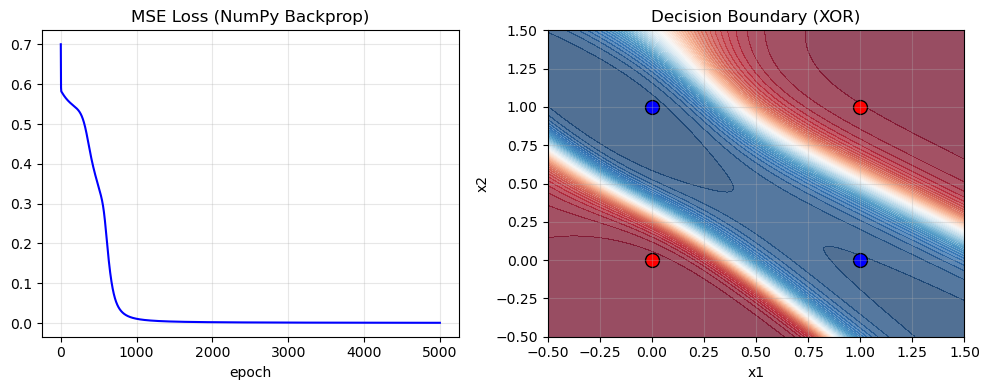

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Loss curve
axes[0].plot(loss_hist, 'b-', lw=1.5)
axes[0].set_title('MSE Loss (NumPy Backprop)'); axes[0].set_xlabel('epoch'); axes[0].grid(alpha=0.3)

# Decision boundary
xx, yy = np.meshgrid(np.linspace(-0.5, 1.5, 200), np.linspace(-0.5, 1.5, 200))
grid = np.c_[np.ones(xx.size), xx.ravel(), yy.ravel()]  # (40000, d+1)

Zg_tilde = sigmoid(grid @ U1.T)                          # z̃ = τ(zsum)
Zg = np.hstack([np.ones((len(grid), 1)), Zg_tilde])      # z = (1, z̃)
Og = sigmoid(Zg @ U2.T)                                  # o = τ(osum)

axes[1].contourf(xx, yy, Og[:, 0].reshape(xx.shape), levels=50, cmap='RdBu', alpha=0.7)
axes[1].scatter(X_xor[Y_xor.flatten()==0, 0], X_xor[Y_xor.flatten()==0, 1], c='r', s=100, edgecolors='k')
axes[1].scatter(X_xor[Y_xor.flatten()==1, 0], X_xor[Y_xor.flatten()==1, 1], c='b', s=100, edgecolors='k')
axes[1].set_title('Decision Boundary (XOR)'); axes[1].set_xlabel('x1'); axes[1].set_ylabel('x2')
axes[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()

---
# 3. PyTorch autograd 검증

수동 구현이 맞는지 PyTorch `backward()`와 비교합니다.

In [44]:
class XOR_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 4)              # 은닉층
        self.fc2 = nn.Linear(4, 1)              # 출력층

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))          # 은닉층 + sigmoid
        return self.fc2(x)                       # logit 반환

torch.manual_seed(42)
model = XOR_MLP()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)

X_t = torch.tensor(X_xor, dtype=torch.float32)
y_t = torch.tensor(Y_xor, dtype=torch.float32)

loss_hist_torch = []
for epoch in range(5000):
    loss = criterion(model(X_t), y_t)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_hist_torch.append(loss.item())

with torch.no_grad():
    pred = torch.sigmoid(model(X_t))
    print('=== XOR PyTorch Result ===')
    for i in range(4):
        print(f'  x={X_xor[i]}  →  o={pred[i].item():.4f}  (target={Y_xor[i,0]:.0f})')

=== XOR PyTorch Result ===
  x=[0. 0.]  →  o=0.0010  (target=0)
  x=[0. 1.]  →  o=0.9983  (target=1)
  x=[1. 0.]  →  o=0.9990  (target=1)
  x=[1. 1.]  →  o=0.0015  (target=0)


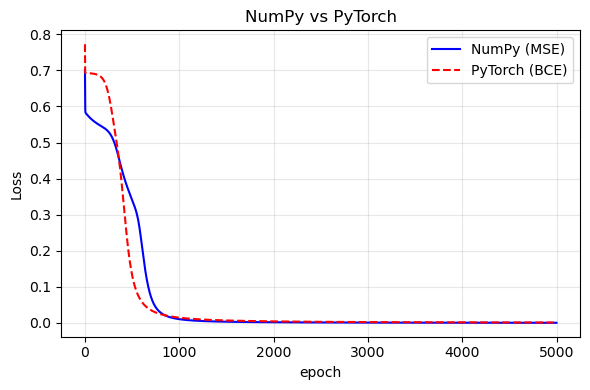

Loss 척도(MSE vs BCE)가 다르지만, 둘 다 XOR을 학습합니다.


In [45]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(loss_hist, 'b-', lw=1.5, label='NumPy (MSE)')
ax.plot(loss_hist_torch, 'r--', lw=1.5, label='PyTorch (BCE)')
ax.set_title('NumPy vs PyTorch'); ax.set_xlabel('epoch'); ax.set_ylabel('Loss')
ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout(); plt.show()
print('Loss 척도(MSE vs BCE)가 다르지만, 둘 다 XOR을 학습합니다.')

---
# 4. Multi-class 출력 시 Criterion 변화

출력이 **binary**에서 **multi-class**로 바뀔 때, activation과 loss가 변합니다.

| | Binary (XOR) | Multi-class |
|---|---|---|
| **출력 노드** | 1 | C (클래스 수) |
| **Activation** | sigmoid | softmax (또는 생략) |
| **Loss** | `BCEWithLogitsLoss` | `CrossEntropyLoss` |
| **Label 형태** | `float (0/1)` | `long (클래스 인덱스)` |
| **예측** | `sigmoid(z) >= 0.5` | `argmax(logits)` |

In [46]:
# --- Binary: sigmoid + BCEWithLogitsLoss ---
print('=== Binary (XOR) ===')

torch.manual_seed(0)
model_bin = nn.Sequential(nn.Linear(2, 4), nn.Sigmoid(), nn.Linear(4, 1))
crit_bin = nn.BCEWithLogitsLoss()
opt_bin = torch.optim.SGD(model_bin.parameters(), lr=1.0)

X_t = torch.tensor(X_xor, dtype=torch.float32)
y_bin = torch.tensor(Y_xor, dtype=torch.float32)   # (N, 1), float

for ep in range(3000):
    loss = crit_bin(model_bin(X_t), y_bin)
    loss.backward(); opt_bin.step(); opt_bin.zero_grad()

with torch.no_grad():
    prob = torch.sigmoid(model_bin(X_t))            # sigmoid로 확률 변환
    pred = (prob >= 0.5).int().flatten()
print(f'  Prediction: {pred.numpy()}')
print(f'  Labels:     {Y_xor.flatten().astype(int)}')
print(f'  Loss: {loss.item():.4f}')

=== Binary (XOR) ===
  Prediction: [0 1 1 0]
  Labels:     [0 1 1 0]
  Loss: 0.0030


In [47]:
# --- Multi-class: CrossEntropyLoss (softmax 내장) ---
print('=== Multi-class (Iris 3-class) ===')

iris = datasets.load_iris()
X_iris = torch.tensor(iris.data, dtype=torch.float32)
y_iris = torch.tensor(iris.target, dtype=torch.long)  # (N,), long 정수 인덱스

torch.manual_seed(0)
model_mc = nn.Sequential(nn.Linear(4, 16), nn.ReLU(), nn.Linear(16, 3))
crit_mc = nn.CrossEntropyLoss()                       # softmax + NLL 내장
opt_mc = torch.optim.Adam(model_mc.parameters(), lr=0.01)

for ep in range(300):
    logits = model_mc(X_iris)                          # (N, 3) — softmax 적용 전
    loss = crit_mc(logits, y_iris)
    loss.backward(); opt_mc.step(); opt_mc.zero_grad()

with torch.no_grad():
    pred = model_mc(X_iris).argmax(dim=1)              # argmax로 예측 클래스 선택
    acc = (pred == y_iris).float().mean()
print(f'  Accuracy: {acc:.1%}')
print(f'  Loss: {loss.item():.4f}')
print(f'\n  y_iris dtype: {y_iris.dtype}  (long 정수 — 클래스 인덱스)')
print(f'  y_bin  dtype: {y_bin.dtype}   (float — 0.0/1.0)')

=== Multi-class (Iris 3-class) ===
  Accuracy: 98.0%
  Loss: 0.0527

  y_iris dtype: torch.int64  (long 정수 — 클래스 인덱스)
  y_bin  dtype: torch.float32   (float — 0.0/1.0)


---
# 5. PyTorch MLP — Digits Classification

sklearn `digits` 데이터셋 (8×8 이미지, 10 클래스)을 MLP로 분류합니다.

### 데이터 로드

Train: torch.Size([1078, 64]), Test: torch.Size([719, 64])
Classes: [0 1 2 3 4 5 6 7 8 9]


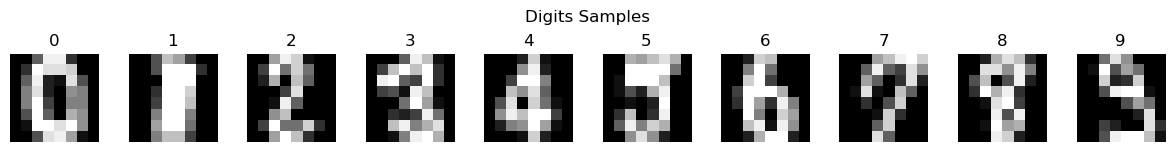

In [48]:
digits = datasets.load_digits()
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, train_size=0.6, random_state=42)

# 정규화 (0~16 → 0~1)
X_train = X_train / 16.0
X_test  = X_test  / 16.0

X_tr = torch.tensor(X_train, dtype=torch.float32)
y_tr = torch.tensor(y_train, dtype=torch.long)
X_te = torch.tensor(X_test, dtype=torch.float32)
y_te = torch.tensor(y_test, dtype=torch.long)

print(f'Train: {X_tr.shape}, Test: {X_te.shape}')
print(f'Classes: {np.unique(y_train)}')

# 샘플 이미지 출력
fig, axes = plt.subplots(1, 10, figsize=(12, 1.5))
for i in range(10):
    idx = np.where(y_train == i)[0][0]
    axes[i].imshow(X_train[idx].reshape(8, 8), cmap='gray')
    axes[i].set_title(str(i)); axes[i].axis('off')
plt.suptitle('Digits Samples'); plt.tight_layout(); plt.show()

### 모델 정의

```
Input (64) → Hidden (100, ReLU) → Output (10)
```

In [49]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)   # 은닉층
        self.fc2 = nn.Linear(hidden_dim, output_dim)  # 출력층

    def forward(self, x):
        x = torch.relu(self.fc1(x))                   # ReLU 활성화
        return self.fc2(x)                             # logits 반환

model = MLP(input_dim=64, hidden_dim=100, output_dim=10)
print(model)
print(f'\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}')

MLP(
  (fc1): Linear(in_features=64, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

Total parameters: 7,510


### 학습

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
n_epochs = 300

loss_hist, acc_hist = [], []

for epoch in range(n_epochs):
    logits = model(X_tr)
    loss = criterion(logits, y_tr)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    acc = (logits.argmax(dim=1) == y_tr).float().mean().item()
    loss_hist.append(loss.item())
    acc_hist.append(acc)

print(f'Train Loss: {loss_hist[0]:.2f} → {loss_hist[-1]:.4f}')
print(f'Train Acc:  {acc_hist[0]:.1%} → {acc_hist[-1]:.1%}')

Train Loss: 2.30 → 2.0007
Train Acc:  4.5% → 69.3%


In [51]:
# 테스트 정확도
with torch.no_grad():
    test_logits = model(X_te)
    test_acc = (test_logits.argmax(dim=1) == y_te).float().mean().item()
    test_loss = criterion(test_logits, y_te).item()

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.1%}')

Test Loss: 2.0062
Test Accuracy: 66.9%


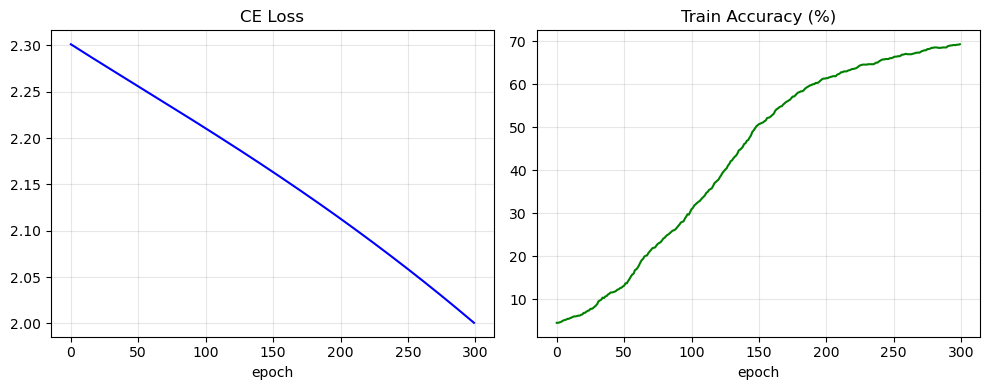

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(loss_hist, 'b-', lw=1.5)
axes[0].set_title('CE Loss'); axes[0].set_xlabel('epoch'); axes[0].grid(alpha=0.3)
axes[1].plot([a * 100 for a in acc_hist], 'g-', lw=1.5)
axes[1].set_title('Train Accuracy (%)'); axes[1].set_xlabel('epoch'); axes[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()

### Deeper MLP

은닉층을 2개로 늘려봅니다.

```
Input (64) → Hidden1 (128, ReLU) → Hidden2 (64, ReLU) → Output (10)
```

In [53]:
class DeepMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))     # 첫 번째 은닉층
        x = torch.relu(self.fc2(x))     # 두 번째 은닉층
        return self.fc3(x)               # 출력층 (logits)

model_deep = DeepMLP()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_deep.parameters(), lr=0.001)

loss_hist_deep, acc_hist_deep = [], []

for epoch in range(n_epochs):
    logits = model_deep(X_tr)
    loss = criterion(logits, y_tr)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    acc = (logits.argmax(dim=1) == y_tr).float().mean().item()
    loss_hist_deep.append(loss.item())
    acc_hist_deep.append(acc)

with torch.no_grad():
    test_acc_deep = (model_deep(X_te).argmax(dim=1) == y_te).float().mean().item()

print(f'Train Acc: {acc_hist_deep[-1]:.1%}')
print(f'Test  Acc: {test_acc_deep:.1%}')

Train Acc: 100.0%
Test  Acc: 97.5%


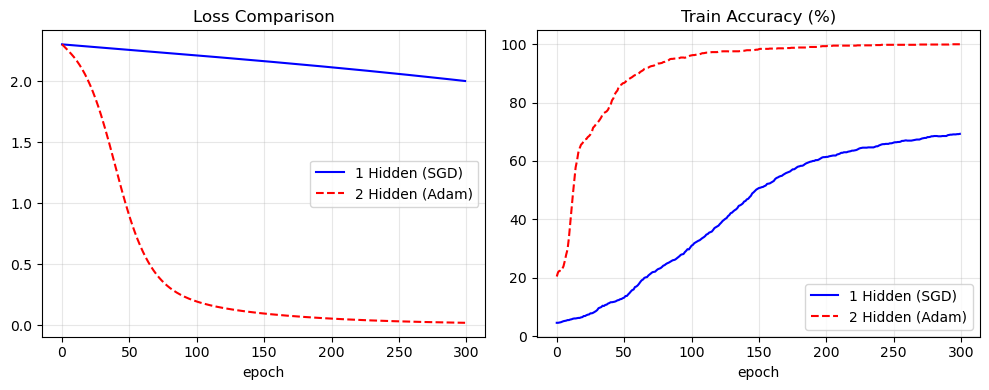

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(loss_hist, 'b-', lw=1.5, label='1 Hidden (SGD)')
axes[0].plot(loss_hist_deep, 'r--', lw=1.5, label='2 Hidden (Adam)')
axes[0].set_title('Loss Comparison'); axes[0].set_xlabel('epoch'); axes[0].legend(); axes[0].grid(alpha=0.3)
axes[1].plot([a*100 for a in acc_hist], 'b-', lw=1.5, label='1 Hidden (SGD)')
axes[1].plot([a*100 for a in acc_hist_deep], 'r--', lw=1.5, label='2 Hidden (Adam)')
axes[1].set_title('Train Accuracy (%)'); axes[1].set_xlabel('epoch'); axes[1].legend(); axes[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()